# Import Libraries

In [1]:
import numpy as np
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import pairwise_distances, silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import skfuzzy as fuzz
from tqdm.notebook import tqdm
import os
from skfuzzy import cluster
import pickle


# Data Preprocessing

In [2]:
data = pd.read_csv('..frontend/data/dataset.csv', index_col=0)
data.drop_duplicates(subset='track_id')
features = ['track_name', 'artists', 'popularity', 'track_genre', 'danceability', 'loudness', 'acousticness', 'valence', 'tempo']
X = data[features].copy()
X.drop_duplicates(subset=['track_name', 'artists'], keep='first', inplace=True)
X.reset_index(drop=True, inplace=True)
# Standardize data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X[['popularity', 'danceability', 'loudness', 'acousticness', 'valence', 'tempo']])

# Define Model

In [4]:
# Apply Fuzzy C Means clustering
n_clusters = 9 # Number of clusters
m = 1.1  # Fuzziness parameter

history = []
X = np.linspace(1.1, 2, 15)
for m in tqdm(X):
    cntr, u, u0,d,jm,p, fpc = fuzz.cluster.cmeans(
        X_scaled.T, n_clusters, m, error=0.005, maxiter=1000, init=None
    )
    history.append(fpc)
u = u.T / np.linalg.norm(u.T, axis=1)[:, np.newaxis]

  0%|          | 0/15 [00:00<?, ?it/s]

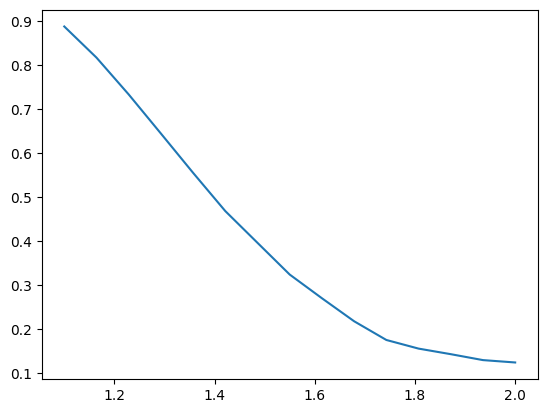

In [5]:
plt.plot(X, history)

In [10]:
with open('models/fuzzy.pkl', 'wb') as file:
    pickle.dump((cntr, u), file)

# FPC for Fuzzy C-Means

A FPC of 0.8788 shows that the fuzzy C-Means algorithm is doing an great job separating our data into groups and Most data points have strong membership in one cluster.

In [6]:
# Display FPC Score
print(f"Fuzzy Partition Coefficient (FPC): {fpc:.4f}")


Fuzzy Partition Coefficient (FPC): 0.1241


# Visualize Clusters

Since we have 5 features, we use dimensionality reduction such as PCA to project the data into 2D

[0.38692401 0.1901674 ]


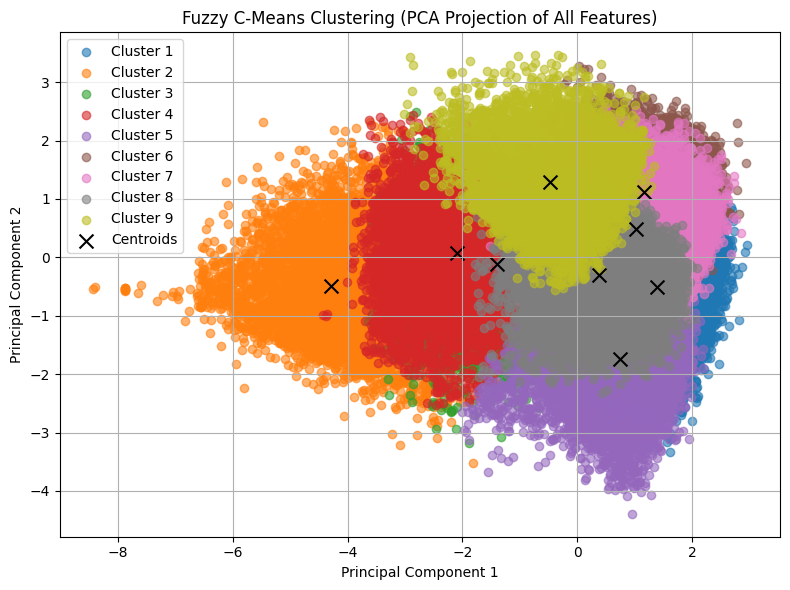

In [52]:
# Reduce all features to 2D using PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
pca.fit(X_scaled)
print(pca.explained_variance_ratio_)

# Convert fuzzy memberships to hard assignments
cluster_membership = np.argmax(u.T, axis=0)

# Plot clusters in PCA space
plt.figure(figsize=(8,6))
for i in range(n_clusters):
    cluster_points = X_pca[cluster_membership == i]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {i+1}', alpha=0.6)

# Project and plot cluster centroids
centroids_pca = pca.transform(cntr)
plt.scatter(centroids_pca[:, 0], centroids_pca[:, 1], c='black', marker='x', s=100, label='Centroids')

plt.title("Fuzzy C-Means Clustering (PCA Projection of All Features)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()




# PCA Based Clustering Information

To visualize the clustering results from the five dimensional features: danceability, loudness, acousticness, valence, and tempo we applied Principal Component Analysis (PCA) to reduce the data to two dimensions.

The first two principal components together explain 65.3% of the total variance in the dataset (40.7% from PC1 and 24.6% from PC2)

This indicate that some information is loss due to dimensionality reduction, but is adequate to show general cluster separation trends


In [53]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
pca.fit(X_scaled)
print(pca.explained_variance_ratio_)

[0.38692401 0.1901674 ]


# Display  Cluster Information

In [54]:
results = X.copy()
results['cluster'] = cluster_membership.astype(str)
print(results['cluster'].value_counts())


cluster
7    11928
6    11374
5    10455
4    10223
0     9552
8     8856
3     7436
2     6940
1     4580
Name: count, dtype: int64


In [55]:
# Make a copy of the data
results = X.copy()

# Add cluster assignments
results['cluster'] = cluster_membership.astype(str)

# Create a DataFrame to store the top 3 genres per cluster
top_genres_list = []

# Loop over each unique cluster
for cluster_id in sorted(results['cluster'].unique(), key=int):
    top_genres = results[results['cluster'] == cluster_id]['track_genre'].value_counts().head(3)
    row = {
        'Cluster': cluster_id,
        'Genre 1': top_genres.index[0] if len(top_genres) > 0 else '',
        'Count 1': top_genres.iloc[0] if len(top_genres) > 0 else 0,
        'Genre 2': top_genres.index[1] if len(top_genres) > 1 else '',
        'Count 2': top_genres.iloc[1] if len(top_genres) > 1 else 0,
        'Genre 3': top_genres.index[2] if len(top_genres) > 2 else '',
        'Count 3': top_genres.iloc[2] if len(top_genres) > 2 else 0,
    }
    top_genres_list.append(row)

# Convert to DataFrame
real_top_genres_df = pd.DataFrame(top_genres_list)
display(real_top_genres_df)

,Cluster,Genre 1,Count 1,Genre 2,Count 2,Genre 3,Count 3
0,0,forro,400,drum-and-bass,342,j-idol,321
1,1,sleep,682,new-age,604,ambient,481
2,2,cantopop,369,acoustic,308,chill,268
3,3,romance,467,comedy,351,opera,350
4,4,grindcore,936,black-metal,881,death-metal,670
5,5,forro,367,k-pop,360,deep-house,300
6,6,chicago-house,858,detroit-techno,716,kids,640
7,7,deep-house,439,minimal-techno,432,progressive-house,402
8,8,tango,515,comedy,423,bluegrass,420


# Create Song Search

In [68]:
title = 'call me maybe'
artist = ''
X[X['track_name'].str.contains(title, na=False, case=False) & X['artists'].str.contains(artist, na=False, case=False)]

,track_name,artists,popularity,track_genre,energy,danceability,loudness,acousticness,valence,tempo
15117,Call Me Maybe (Glee Cast Version),Glee Cast,41,club,0.640,0.754,-5.595,0.1140,0.722,120.030
25554,Call Me Maybe,Carly Rae Jepsen,80,electro,0.580,0.783,-6.548,0.0114,0.660,120.021
50718,Call Me Maybe,Kids Rock Kidz,16,kids,0.716,0.736,-6.875,0.0660,0.610,120.064


# Create Playlist Song Recommendation

In [69]:
# Extract the scaled feature vectors and transpose them
# X_playlist = u.T[playlist].mean(axis=0) # must be (features x samples)

playlist = [25554] # [50201, 49937]

# Get indices of songs in the same cluster
indices = results.index

# Compute song_score for each song in the same cluster
song_score = []
for song in indices:
    score = float('-inf')
    for liked_song in playlist:
        mse = u[song] @ u[liked_song].T
        score = max(score, mse)
    song_score.append(score)

# Select top_k based on playlist length
top_k = len(playlist) + 10
song_score = np.array(song_score)
most_similar = np.argsort(song_score)[::-1][:top_k]# np.argpartition(song_score, top_k)[:top_k]

# Retrieve the recommended songs
recommended_songs = results.iloc[most_similar]

Display Current Selection

In [70]:
display(recommended_songs)

,track_name,artists,popularity,track_genre,energy,danceability,loudness,acousticness,valence,tempo,cluster
25554,Call Me Maybe,Carly Rae Jepsen,80,electro,0.580,0.783,-6.548,0.01140,0.660,120.021,5
77695,The Mirage,Agents Of Time,53,techno,0.866,0.724,-7.028,0.06580,0.525,126.000,5
41649,Pinnak,SAMBATA,56,hip-hop,0.684,0.781,-8.303,0.01100,0.543,100.587,5
41714,Sirikkalam Parakkalam,Benny Dayal;Madurai Soulijos,57,hip-hop,0.834,0.703,-5.491,0.03960,0.537,127.944,5
3881,Black Catcher,Vickeblanka,68,anime,0.892,0.586,-5.259,0.00079,0.665,100.040,5
60589,Adheeraa,A.R. Rahman;Vagu Mazan;Thoughtsfornow,66,pop-film,0.835,0.722,-9.082,0.10700,0.558,110.962,5
70316,Say My Name,Alex Brightman;Sophia Anne Caruso;Kerry Butler...,66,show-tunes,0.754,0.534,-5.937,0.34500,0.702,93.646,5
53721,我相信,楊培安,52,mandopop,0.768,0.668,-4.652,0.04370,0.542,112.040,5
69823,Amor de Primavera - Ao Vivo,Gusttavo Lima,48,sertanejo,0.852,0.634,-3.506,0.38100,0.566,100.034,5
19496,Shadow,Syn Cole;Alida,60,deep-house,0.718,0.786,-6.292,0.00519,0.525,123.951,5
